In [2]:
from IPython.display import Image

# Diary content:

1. [Neural Architectures for Named Entity Recognition (2016)](#1)

2. [Deep contextualized word representations (2018)](#2)

3. [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (2019)](#3)

4. [A Unified Architecture for Natural Language Processing: Deep Neural Networks with Multitask Learning (2008)](#4)

5. [Recurrent Neural Network for Text Classification with Multi-Task Learning (2016)](#5)

# <a id=1>Neural Architectures for Named Entity Recognition</a>

https://arxiv.org/pdf/1603.01360.pdf

#### Abstract

В статье предлагаются к рассмотрению две архитектуры нейронных сетей: LSTM+CRF (Condition Random Field) и еще одна, "конструирующая и помечающая сегменты, используя transitionl-based подход, вдохновленный shift-reduce парсерами" (последнее - такой подход к синтаксическому анализу грамматик). Модели используют два источника информации - небольшой размеченный датасет и большой неразмеченный.

#### Introduction

Во вступлении отмечается, что почти все популярные до этого подходы требовали либо огромных размеченных корпусов, либо всяких "рукописных" специфичных для данного языка фич, а также иных источников информации. Они же утверждают, что для качественного извлечения фич достаточно может быть лишь небольшого размеченного "корпус" вкупе с неразмеченным побольше, без всяких изощрений. В своей работе они придерживались двух основных соображений:

1) Для любого токена важно принимать решение о его разметке, учитывая его соседей

2) Так как свойство "быть именем" подразумевает под собой как некоторые орфографические свойства, так и дистрибутивные. Первые можно уловить при помощи character-based представлений слов, комбинируя их со вторыми - дистрибутивными (ссылка на Mikolov-а).

### LSTM-CRF Model

#### LSTM

Описывается используемая ими, немного упрощенная по сравнению с классической структура LSTM (в частности, используется меньше гейтов). Думаю, подробного описания не нужно.

#### CRF Tagging Models

Главный посыл в принятии решения о том или ином тэге токена с учетом других токенов предложения. Пусть дано входная последовательность:

$$
X = (x_1, x_2, ..., x_n)
$$

Определим матрицу $P \in \mathbb{R}^{n\times k}$ как выход biLSTM, где k - число различных тэгов, $P_{ij}$ соотвествует "скору" j-го тэга i-го слова. Для последовательности предсказаний:

$$
y = (y_1, y_2, ..., y_n)
$$

определим ее скор как:

$$
s(X,y) = \sum\limits_{i=0}^nA_{y_i, y_{i+1}} + \sum\limits_{i=1}^nP_{i, y_{i}}
$$

где A есть матрица скоров переходов, то есть $A_{i,j}$ есть скор перехода от тэга i к тэгу j. Таким образом, суммарный скор задается вполне естественным образом: как сумма скоров переходов (который говорит о том, насколько вообще вероятна такая последовательность тэгов) + сумма скоров каждого из слов по отдельности (то есть насколько вероятно поставить такой тэг такому-то слову по отдельности). Под $y_0$ и $y_n$ всегда подразумеваются тэги start и end, поэтому $A \in \mathbb{R}^{k+2\times k+2}$. 

Применив софтмакс ко всем возможным последовательностям тэгов, получим вероятность последовательности $y$:

$$
p(y|X) = \frac{e^{s(X,y)}}{\sum_{\widetilde{y}\in Y_X}e^{s(X, \widetilde{y})}}
$$

Теперь, во время обучения можно просто максимизировать log-probability истинной последовательности символов:

$$
log(p(y|X)) = s(X,y) - log\Big(\sum\limits_{\widetilde{y}\in Y_X}e^{s(X, \widetilde{y})}\Big) = s(X,y) - \underset{\widetilde{y}\in Y_X}{logadd} \: s(X, \widetilde{y})
$$

$Y_X$ - всевозможные наборы тэгов.

Тогда, на инференсе, модель делает предсказание очевидным образом:

$$
y^* = \underset{\widetilde{y}\in Y_X}{argmax} \: s(X, \widetilde{y})
$$

Матрица P определяется эмбеддигнами "слов в контексте", полученными при помощи biLSTM, а матрица A есть матрица оценок "совместимости" биграм.

Таким образом, после прохождения biLSTM, полученные векторы конкатенируются, проецируются на размерность, равную числу различных тэгов, и затем к ним применяется CRF для получения предсказаний.

Для тэггирования используется схема IOBES (Inside, outside, beginning, end, singleton).

### Transitional-Based Chunking Model

Так как нам важнее была первая часть, то эту опишем вкратце.

В основе второго из предложенных подходов лежит использование Stack-LSTM. В отличие от обычных последовательных LSTM они позволяют использовать стек объектов (с классическими операциями push и pop), что делает возможным поддерживать "суммарный эмбеддинг" содержимого стека.

Во время оработки входной последовательности используется предложенный им "chunking algorithm". В нем используются два стека: стек выхода (для готовых "кусков") и обработки (подготовка "кусков") , а также буффер слов, которые надо обработать. Переходы между ними задаются операциями: SHIFT(из буфера в стек обработки), OUT (сразу из буфера в выходной стек), а также REDUCE(y), который достает все слова из стека обработки, отмечает их лейблом y и отправляет в выходной стек. Алгоритм заканчивает свою работу когда буфферы и стеки пусты.

Модель старается предсказать вероятностное распределение того, какое действие надо выполнить на каждом шагу. Решение принимается на основе состояний стеков, буффера, а также "прошлом". S-LSTM используются для нахождения эмбеддингов всех составляющих алгоритма, которые затем конкатенируются и дают полное состояние на данный момент времени. Модель обучена на максимизацию условной вероятности последовательности "эталонных" действий для данного входа.

#### Input Word Embeddings

На вход модели подаются эмбеддинги слов, которые есть результат конкатенации двух векторов:

1) Character-based embedding, полученный с использованием biLSTM

2) Pretrained word embeddings, полученные с использованием skip-n-gram

Над итоговыми эмбеддингами также используется дропаут.

#### Experiments

SGD, lr=0.01, gradient clipping = 5.0, LSTM dim=100, dropout rate = 0.5.

#### Results

По итогу тестирования моделей на CoNLL-2002 и CoNLL-2003 датасетах, LSTM-CRF порвал всех с кем сравнивали, вне зависимости от языка и датасета.

## <a id=2>Deep contextualized word representations</a>

https://arxiv.org/pdf/1802.05365.pdf

Статья про ELMO

#### Abstract

Авторы предлагают новый способ получения "глубогих" представлений слов, в которые заложены как сложные характестики самих слов (семантические и тд), так и характеристики, связанные с их использованием в различных лингвистических контекстах. Векторы слов есть функции внутренних состояний глубокой двунаправленной лингвистической модели (biLM), которая предобучается на большом "корпусе". Готовые векторы можно легко добавить ко входу любой модели, что даст заметный прирост ее качества.

#### Introduction

Представления, которые дает Элмо отличаются от классических тем, что по каждый токен представляется функцией, зависящей от всего входного предложения. Для получения представления они используют векторы, полученные из предобученной biLSTM, поэтому и называют их Elmo (Embeddings from Lamguage Models). По сути, эти представления есть линейная комбинация векторов, полученных на каждом слое модели. Это придает модели некоторую гибкость: в начальных слоях обычно "кроется" информация об особенностях самого слова, в конечных - об особенностях контеста. 

### ELMo: Embeddings from Language Models

#### Bidirectional lamguage models

Все по классике: пусть дана последовательность из N токенов $(t_1, ..., t_N)$, forward model пытается считать вероятность:

$$
p(t_1, t_2, ..., t_N) = \prod_{k=1}^{N}p(t_k|t_1, t_2, ..., t_{k-1})
$$

аналогично с backward model:

$$
p(t_1, t_2, ..., t_N) = \prod_{k=1}^{N}p(t_k|t_{k+1}, t_{k+2}, ..., t_{N})
$$

Вся biLM обучается на максимизацию вероятности:

$$
\sum\limits_{k=1}^{N}(log \: p(t_k|t_1, t_2, ..., t_{k-1}, \Theta_x, \overset{\rightarrow}{\Theta}_{LSMT}, \Theta_s) + log \: p(t_k|t_{k+1}, t_{k+2}, ..., t_{N}, \Theta_x, \overset{\leftarrow}{\Theta}_{LSMT}, \Theta_s)),
$$

где $\Theta$-ы - параметры модели.

Обозначим за $x_{k}^{LM}$ представление k-го слова на входе, $\overset{\rightarrow}{h}_{k,j}^{LM}$ - выходные векторы k-ой позиции j-го слоя forward LSTM (j = 1,...,L), а $\overset{\leftarrow}{h}_{k,j}^{LM}$ - выходные векторы k-ой позиции j-го слоя backward LSTM (j = 1,...,L). Все множество из 2L+1 представления токена t_k обозначим как:

$$
R_k = \{x_{k}^{LM}, \overset{\rightarrow}{h}_{k,j}^{LM}, \overset{\leftarrow}{h}_{k,j}^{LM}| j=1, ..., \} = \{h_{k,j}^{LM}|j=0,...,L\}
$$

Для использования в последующей модели Элмо собирает все векторы в один итоговый 

$$
ELMO\,^{task}_k = E(R_k, \Theta^{task}) = \gamma^{task}\sum\limits_{j=o}^{L}s_j^{task}h_{k,j}^{LM}
$$

task подчеркивает, что для каждой задачи подбираются свои коэффициенты, $s^{task}$ - softmax-нормированные веса, $y^{task}$ - скалярный параметр.

#### Using biLMs for supervised NLP tasks

Имея предобученную biLM и готовую архитектуру для целевой задачи очень просто "встроить" в нее ELMo-представления: каждой входной токен мы прогоняем через biLM, затем "целевая" модель обучает коэффициенты линейной комбинации для полчения нужного ей ELMo-представления.

Для добавления ELMo в supervised-модель, мы замораживаем веса biLM и конкатенируем вектор $ELMO_k^{task}$ со входным вектором $x_k$ и подаем результат модели. Также полезной может оказаться конкатенация ELMO_k^{task} с выходом первого слоя supervised-модели $h_k$.

Помимо этого, для регуляризации можно использовать dropout над ELMo или добавить $\lambda||w||_2^2$ к лоссу.

#### Pre-trained bidirectional language model architecture

Архитектура модели взаимствована из статьи __Exploring the Limits of Language Modeling__. Сначала получаем context insensitive представление: применяются 2048 символьных n-gram сверток, затем полученный вектор проходит через два highway-слоя и проецируется на вектор размерности 512. После этого идут два слоя biLSTM с residual connection от первого ко второму. Как результат - три различных представления на каждом из слоев: context insensitive, 2 LSTM, линейную комбинация выходов которых и образует конечное представление.

PS: highway layer позволяет модели решить, нужно ли добавить нелинейность к вектору и обычно имеет следующий вид:

$$
y = g(x)T(x) + x(1-T(x))
$$
$$
T(x) = \sigma(Wx+b)
$$

g - та самая нелинейность.

#### Analysis

Предложенный способ получения представлений слов позволяет улавливать как структурные особенности самого слова, так и особенности его контекста, что дает значительное улучшение качества при его использовании во множестве задач.

#### Appendix

Ссылка на статью Exploring the Limits of Language Modeling (2016):

https://arxiv.org/pdf/1602.02410.pdf

Хорошая статья с объяснением CNN-сверток в задачах NLP - Character-Aware Neural Language Models (2015):

https://arxiv.org/pdf/1508.06615.pdf

## <a id=3>BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding</a>

https://arxiv.org/pdf/1810.04805.pdf

#### Abstract
Берт разработан для предобучения "глубоких" представлений с использованием двунаправленной сетки на неразмеченном тексте.

#### Introduction
Существуют две основные стратегии применения предобученных языковых представлений:

* feature-based подход (как, например, с ELMO, чей выход просто добавляется ко входу (конкатенируется с ним)

* fine-tuning подход (когда берется готовая неспецифицированная предобученная модель и дообучается под конкретную задачу)

Во время предобучения предлагается использовать "Masked language model" objective, когда случайные входные токены маскируются и модель учат предсказывать их id. При этом, разрешается использовать как правый, так и левый контексты, так что мы получаем как бы двунаправленный трансформер.

Также используется "next sentence prediction"-задача, направленная на предобучение текстов попарно (предложений).

В итоге, по их словам, получается супер state-of-the-art.

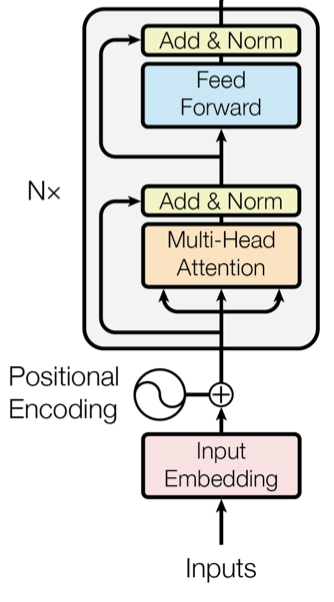

In [7]:
Image(filename='Images/Encoder.png')

### BERT

Использование модели очевидным образом разбивается на ее предобучение и fine-tuning. Во время первого модель учится на различных задачах с использованием неразмеченного текста. Во время второго берутся параметры, полученные во время предобучения, а затем файн-тьюнятся под конкретную задачу с использованием поверх берта нужной архитектуры. В этом то и кроется отличительная черта Берта: в нем нет никакой специфичности, его можно использовать для большого числа различных задач.

#### Model architecture

По сути, BERT - многослойный двунаправленный энкодер из Трансформера. 

Обозначим число слоев (блоков энкодера) - L, размерность hidden векторов H (все выходы всех частей Трансформера имеют одинаковую размерность), число self-attention head - A.

__$BERT_{BASE}$__: L=12, H=768, A=12 (Total parameters=110M)

__$BERT_{LARGE}$__: L=24, H=1024, A=16 (Total parameters=340M)

#### Input/Output Representations

Для того, чтобы Берт был способен справляться с большим числом различных задач, он спроектирован так, что на вход можно подавать как просто предложения, так и пары предложений (например, вопрос-ответ).

Для представления слов используются WordPiece embeddings, в словаре которых 30к английский слов, вполне себе достаточно. Первый токен каждой последовательности - специальный classification токен ([CLS]). Итоговое скрытое состояние модели, полученное из него используется для задач классификации. В случае использования на вход пар предложений (A, B) они разделяются токеном [SEP]. Также, предобучается два дополнительных эмбеддинга соотвествия первому и второму предложениям, которые добавляются к их векторам их токенов.

Для данного входного токена его входное представление формируются в результате суммирования: его эмбеддинга, segment-эмбеддинга соотвествия предложению и позиционного эмбеддинга.

#### Pre-trainining BERT

__Task #1: Masked LM__

Для того чтобы получить глубокие "двунаправленные" представления токенов фиксированная доля входа маскируется (используя специальный токен [MASK]) случайным образом, после чего модель пытается угадать, кто там находится. Такую процедуру называются "Masked LM". Итоговый hidden-вектор, соотвествующий маскированному токену, скармливается софтмаксу для получения предсказания. Они маскировали 15% входа.

Чтобы, насколько это возможно, избежать несоотвествия между предобучением и файн-тьюнингом, которое возникает из-за использования токена [MASK], случайно выбранный слова не всегда заменяются на этот токен: в 80% случаев им ставят токен [MASK], в 10% - случайный токен и в 10% - оставляют старый, после чего все равно используется softmax для предсказания истинного токена.

__Task #2: Next Sentence Prediction (NSP)__

Для того, чтобы обучить модель "понимать" связь между предложениями, во время пред-обучения используется задача "next sentence prediction". Более формально: во время выбора пар предложений (A,B) каждого примера для предобучения - в 50% случаев B берется как действительно следующее за A предложения (тогда пару помечают как IsNext), а в других 50% случаев B берется случайно из данных (и тогда помечаются NotNext). При этом, для принятия решения IsNext или NotNext используется final hidden вектор, полученный из токена [CLS].

__Pre-training data__

Для предобучения использовались BooksCorpus (800М слов) и English Wikipedia (2,500M слов).

#### Fine-tuning BERT

Тут все просто: на вход берту подается соотвествующий задаче вход, выход модели используется в зависимости от задачи. Пары предложений (A,B), используемые для пред-обучения, на этапе файн-тьюнинга в зависимости от задачи могут быть:

1) Парой предложений в задаче перефразирования

2) Парой гипотеза - "предпосылка" в задаче установления логического следствия

3) Вопрос-ответ в задаче QA

4) Текст-$\emptyset$ в задаче классификации или тэггирования.

#### Experiments

__GLUE (The General Language Understanding Evaluation__

Выход берта в позиции, соответвутствующей первому токену [CLF] проецировался на пространство числа выходных лейблов, затем для предсказания применялся софтмакс. Как итог - $BERT_{LARGE}$ всех порвал, на втором месте - $BERT_{BASE}$.

__SQUAD v1.1/ SQUAD v2.0__

Берты снова всех порвали, уже в задаче QA.


#### Conclusion

Ура, Берт всех победил!

#### Appendix

Статья, где был предложен трансформер:

https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf

Хорошая реализация Трансформера на торче:

http://nlp.seas.harvard.edu/2018/04/03/attention.html

## <a id=4>A Unified Architecture for Natural Language Processing: Deep Neural Networks with Multitask Learning</a>

https://dl.acm.org/doi/abs/10.1145/1390156.1390177

#### Abstract

В статье предлагается модель, которая для данного предложения одновременно атпутит предсказаниям по part-of-speech тэгам, chunk-ам, NER тэгам, семантическим смыслам, семнантически схожие слова и вероятность того, что это предложение вообще несет в себе какой-то смысл. Этого помогает достичь multitask learning подход (с использованием общих весов), а так же semi-supervised learning.

#### Introduction

Вместо изобретения различных архитектур для каждой задачи авторы хотят подробовать изобрести нечто более универсальное при наименьших затратах размеченных данных.

Модель обучается всем указанным задачам сразу (на размеченных текстах). Помимо этого, она обучается на неразмеченной википедии. Таким образом, получается semi-supervised подход. 

#### NTP tasks

* POS

* Chunking (shallow parsing) - разметка "кусков" предложения, имеющих некоторую "синтаксическую согласованность", такие как глагольные или существительные фразы. Каждое слово обозначается либо как начало чанка, не либо как его внутренняя часть.

* NER

* Semantic Role Labeling - нацелен на придание смысловой роли синтаксической составляющей предложения. Пример такой разметки: "$[John]_{ARG0}[ate]_{REL}[the \: apple]_{ARG1}$". При этом, каждому слову могут соотвествовать несколько тэгов.

* Language models - оценка вероятности след слова при данном прошлом.

* Semantic Related Words

#### General Deep Architecture for NLP

Они используют CNN над обучаемыми векторами представлений слов + Max Over Time (типа max pooling), затем идут обычные dense слои, в конце - софтмакс.

#### Multitasking with Deep NN

Это такой подход, когда мы пытаемся обучиться сразу нескольким задачам с целью получения взаимной выгоды между ними (типа одна задача дает возможность извлечь такие-то "признаки", другая - другие, короче, они сотрудничают и в результате получается лучшая обобщающая способнось).

Треин происходит следующим образом:

1) Выбрать новую задачу

2) Выбрать случайный пример для этой задачи

3) Сделать шаг град спуска

4) Вернуться к пункту 1

При этом, в их случае, модели имели лишь общие lookup-таблицы (таблицы с обучаемыми представлениями векторов)

Для обучениям множеству задач (по их мнению) возможны два подхода:

1) Сначала обучить фичи на одной задаче, затем использовать их как готовые в другой

2) Учиться сразу куче задач, если есть датасет, который может это позволить. Этот вариант им больше по нраву.

#### Leveraging Unlabeled Data

Их Language Model также обучается на неразмеченном датасете из Википедии, пытаясь предсказать для данного контекста и какого-то слова в нем, действительно для оно из него или же оно какое-то взятое случайно слово.

Кстати, сначала они обучали именно отдельно эту Language Model (целую неделю), потом использовали обученные веса для дообучения.

#### Experiments & Results

Ну у них получились неплохие эмбеддинги (еще бы, целая Википедия), получились какие-то непохие по тому времени результаты на различных задачах.

#### My conclusion

Мне не очень понравилась статья, видимо, слишком древняя. Возможно, для тех времен это было каким-то новшеством.

## <a id=5> Recurrent Neural Network for Text Classification with Multi-Task Learning </a>

https://arxiv.org/pdf/1605.05101.pdf

#### Abstract

В последнее время нейронки добились значительного прогресса во множестве NLP-задач. Однако, в большинстве случаев, модели обучаются на одной supervised задаче и часто страдают от нехватки данных. В связи с этим авторы решили попробовать MLT (multitask learning) подход, обучаясь сразу нескольким похожим задачам. Взяв за основу RNN, они разработали 3 возможных механизма обмена информации между таск-специфик и общими слоями.

#### Introduction

Глубокие сетки как правило нуждаются в больших объемах данных для обучения, так как имеют кучу параметров. Данные как правило дороги, поэтому часто модель сначала обучают на каком-нибудь большом неразмеченном тексте (например, предсказанию слов), а затем файн-тьюнят на целевую задачу, используя размеченную выборку. 

MTL использует связь между схожими задачами с целью улучшить качество классификации, обучаясь им параллельно. В основе таких моделей обычно лежит общее использоваие некоторых слоев, за которыми идут task-specific слои.

Они предлагают три возможные архитектуры: первая модель с использованием лишь одного общего слоя, вторая - каждая модель использует свои слои, но "каждый слой может читать информацию с другого слоя", третья - у каждой модели свои слои + есть общие слои для всех задач вместе. При этом, в третьей модели используется механизм гейтов, позволяющий каждой модели решить, нужна ли ей общая информация.

Утверждается, что такой мультитаск подход им помог обойти большинство state-of-the-art бейзлайнов на нескольких задачах.

#### RNN for Specific-Task Text Classification

Дабы избежать проблем с exploding и vanishing of gradients авторы решили использовать LSTM. 

-----------
Освежалка памяти для меня: каждая нода LSTM по сути есть коллекция векторов из $\mathbb{d}$ (d - предопределенная размерность): input gate $i_t$, forget gate $f_t$, output gate $o_t$, memory cell $c_t$ и hidden state $h_t$. Вычисления имеют вид:

$$
i_t = \sigma(W_ix_t+U_ih_{t-1}+V_ic_{t-1})
$$
$$
f_t = \sigma(W_fx_t+U_fh_{t-1}+V_fc_{t-1})
$$
$$
o_t = \sigma(W_ox_t+U_oh_{t-1}+V_oc_{t-1})
$$
$$
\widetilde{c}_t = tanh(W_cx_t + U_ch_{t-1})
$$
$$
c_t = f_t\odot c_{t-1}+i_t\odot \widetilde{c}_t
$$
$$
h_t = o_t\odot tanh(c_t)
$$

------------

Для получения предсказания по каждой из задач, они берут финальный hidden вектор (соотвествующий последнему обработанному слову) и применяют к нему софтмакс слой.

#### Three Sharing Models for RNN based Multi-Task Learning

Все три предложенные архитектуры можно увидеть на картинке

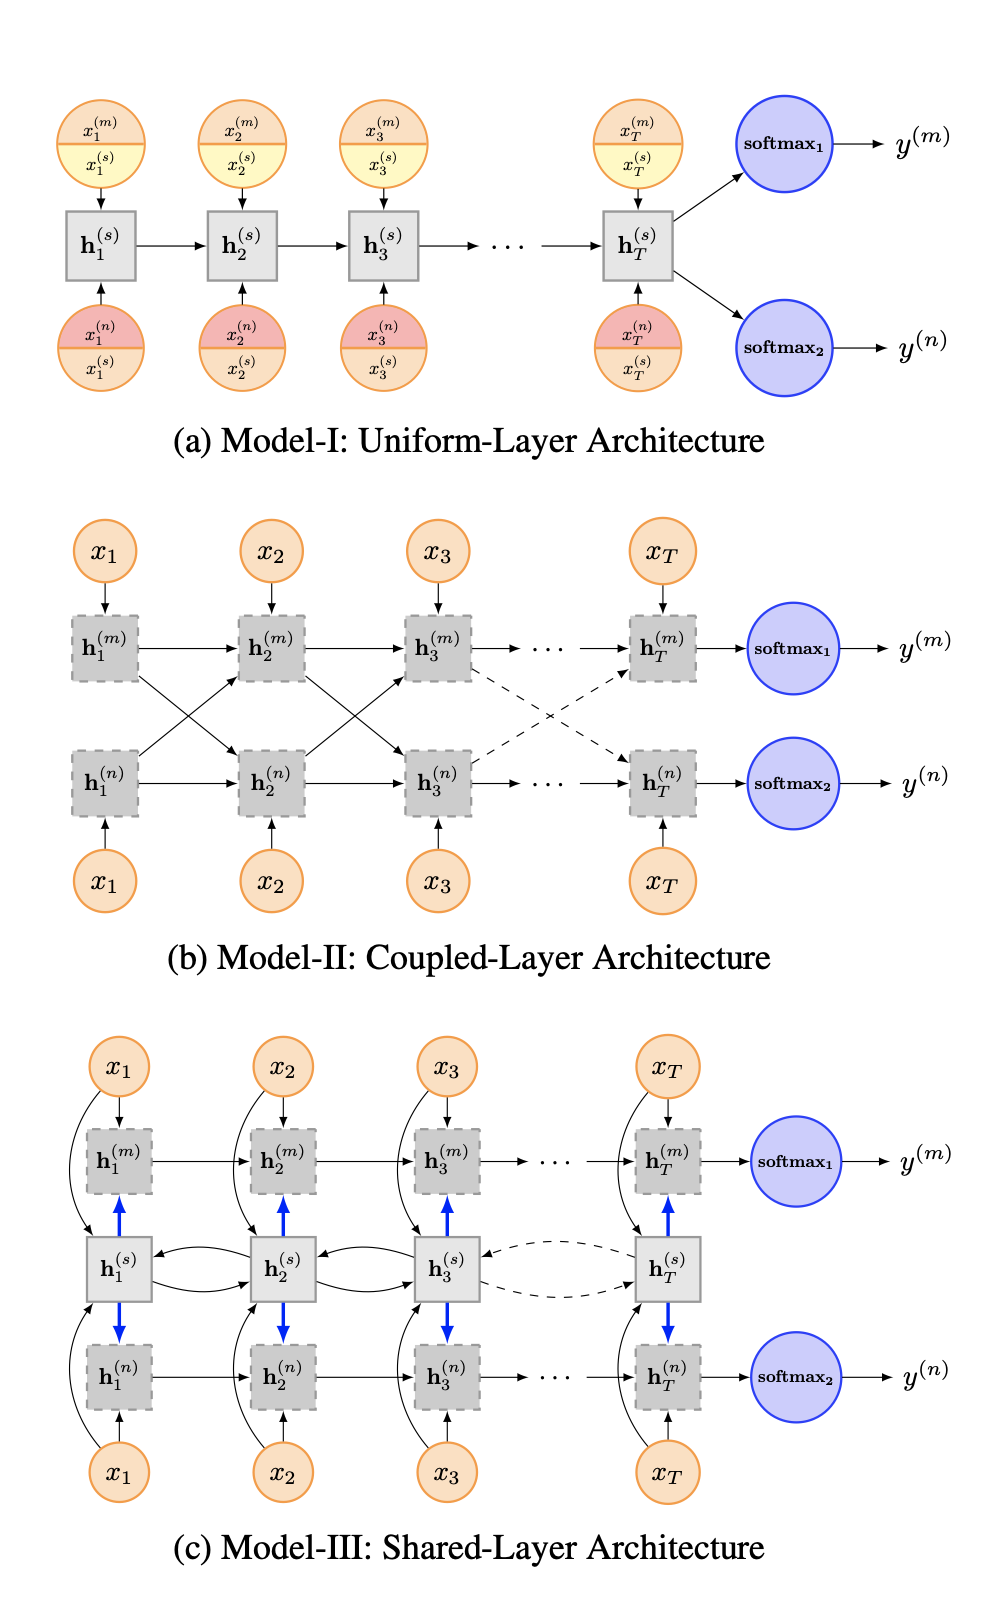

In [8]:
Image(filename="Images/Model2.png")

__Model 1__

В первой модели у всех задач общие слой LSTM и эмбеддинг также эмбеддинг слой за исключением их собственных эмбеддингов. Для задачи m вход $x_t$ состоит из двух частей:

$$
\hat{x}_t^{(m)} = x_t^{(m)} \oplus x_t^{(s)}
$$

где $x_t^{(m)}$ - task-specific эмбеддинг, $x_t^{(s)}$ - shared эмбеддинг, а $\oplus$ - операция конкатенации.

Финальное состояние LSTM:

$$
h_T^{(m)} = LSTM(\hat{x}^{(m)})
$$

__Model 2__

У каждой задачи свой LSTM, но они могут "общаться".

Для пары задач (m,n) обозначим на шаге t их скрытые состояния как $h_t^{(m)}$ и $h_t^{(n)}$. Для того, чтобы модели могли информацией друг с другом переопределяется кандидат на новое значение memory cell:

$$
\widetilde{c}_t^{(m)} = tanh\Big(W_c^{(m)}x_t + \sum\limits_{i\in(m,n)}g^{(i\rightarrow m)}U_c^{(i\rightarrow m)}h_{t-1}^{(i)}\Big)
$$

где $g^{(i\rightarrow m)}=\sigma(W_g^{(m)}x_t + U_g^{(i)}h_{t-1}^{(i)})$. Таким образом, на каждом шаге слой использует hidden вектор предыдущего шага всех остальных LSTM.

В конце концов получаются несколько финальных hidden-векторов для каждой из задач.

__Model 3__

Помимо обычной forward LSTM для каждой из задач, используется еще общий biLSTM-слой. Обозначим выход общего слоя на шаге t как: $h_t^{(s)} = \overset{\rightarrow}{h}_t^{(s)} \oplus \overset{\leftarrow}{h}_t^{(s)}$.

Модели могут сами "решать", нужна ли им информация из общего слоя при помощи гейта:

$$
\widetilde{c}_t^{(m)} = tanh\Big(W_c^{(m)}x_t + g^{(m)}U_c^{(m)}h_{t-1}^{(m)} + g^{(s\rightarrow m)}U_g^{(m)}h_{t-1}^{(m)}\Big)
$$

где $g^{(m)} = \sigma(W_g^{(m)}x_t + U_g^{(m)}h_{t-1}^{(m)})$ и $g^{(s\rightarrow m)} = \sigma(W_g^{(m)}x_t+U_g^{(s\rightarrow m)}h_t^{(s)})$

#### Training

Во время тренировки лосс определяется как линейная комбинация лоссов каждой из подзадач:

$$
\Phi = \sum\limits_{m=1}^{M}\lambda_mL(\hat{y}^{(m)}, y^{(m)})
$$

(правда откуда берутся лямбы они вроде не упомянули).


Так как данные для каждой из подзадач могут отличаться, то тренировка снова происходит в стохастической манере:

1) Берем случайную задачу

2) Берем случайный пример из обучающей выборки для этой задачи

3) Делаем шаг градиентного спуска

4) Возвращаемся к шагу 1

В 1 и 3 моделях после этапа общего обучения можно пофайнтьюнить на любую из задач.

В 3й модели можно предобучить общий слой на unsepervised задаче.

#### Experiments & results

Третья версия модели оказалась наиболее удачной из всех и обошла всякие топовые модели своего времени

#### My conclusion

Как по мне, идея хорошая, но архитектура простовата.